코드 생성

In [979]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from mpl_toolkits.mplot3d import Axes3D
from collections import deque  
import random as rand

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]
# -5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
def getCode(satsNum):
    
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
     
    # result
    g = []
    
    # Generating 1023 chips(One C/A sequence)
    for i in range(1023):
        val = (g1[9] + g2[satsNum[0]] + g2[satsNum[1]]) % 2
        g.append(val)
        
        #shift g1
        g1[9] = sum(g1[i] for i in g1tap) % 2
        g1.rotate()
        
        #shift g2
        g2[9] = sum(g2[i] for i in g2tap) % 2
        g2.rotate()
    # 0 => -1
    for n,i in enumerate(g):
            if i==0:
                g[n]=-1
        
    return g

# 코드 미리 만들어두기(시간복잡도 줄이려고)
codes = []
for i in range(37):
    codes.append(getCode(sats[i]))

In [980]:
OV = 10
ms = 100 # message 한 bit 마다 20ms #원래는 2초 봐야해서 2000



# C/A code Frequency : 1.023MHz
# IF Frequency : 9.548MHz
# Sampling rate : 38.192MHz
# OV should be 4.
# 알아낸 곳: Kai Borre의 A Software-Defined GPS and Galileo Receiver에서의 p.55(pdf 상으로는 70페이지)
# 이것들 적용해야 하는데, 아직 할 줄 모른다...

Noise 생성

In [981]:
# 잡음의 전력 비 설정 (잡음은 전력 1, 신호전력은 1/6.31 이런 식으로 만들기)
noise_power = 6.31 # For -8dB. If -22dB, set noise_power to 158.49
#noise_power = 0.00001
# 잡음의 크기 설정
num_samples = 1023 * ms * OV

# 실수부와 허수부에 대한 잡음 생성
real_noise = np.random.normal(0, 1, num_samples) / (np.sqrt(2) * np.sqrt(OV))
imaginary_noise = np.random.normal(0, 1, num_samples) / (np.sqrt(2) * np.sqrt(OV))

# 복소수로 변환
complex_noise = (real_noise + 1j * imaginary_noise) 

# 신호가 쓸 거
sigma = np.sqrt(noise_power)

Data 생성

In [982]:
data = []
"""
for i in range(ms//20):
    data.append((-1)**i)
"""
RN = rand.randint(0,36)
t_code = codes[RN]
t_code = [chip/(sigma*np.sqrt(OV)) for chip in t_code for _ in range(OV)]
t_code_inv = [x*-1 for x in t_code]
seq = []

#data = [1,1,1,1,1]
data = [1,-1,1,-1,1]
#data = [1,1,1,-1,-1]
#data = [1,-1,1,1,-1]

for d in data:
    if d == 1:
        seq.extend(t_code*20)
    else:
        seq.extend(t_code_inv*20)
        

cor_data = []
for value in data:
    cor_data.extend([value] * 20)


Signal 생성

In [983]:
def generate_transmitted_signal(code_delay, doppler_freq, svNumber, code_freq, signal_length, OV = 1.023e6*OV):
    # delayed_seq = np.roll(seq, code_delay) # code_delay : delay된 sample 수
    t = np.arange(signal_length)
    code_phase = 2 * np.pi * code_freq * t / OV
    ct = np.cos(code_phase) * seq
    oversampled_signal = np.cos(code_phase) * np.exp(1j * (2 * np.pi * doppler_freq * t / OV))
    #oversampled_signal = np.exp(1j*(2*np.pi * (code_freq + doppler_freq) * t / OV))
    signal = ct * oversampled_signal[:signal_length] + complex_noise
    delayed_signal = np.roll(signal, code_delay)
    return delayed_signal

Replica 신호 생성

In [984]:
def generate_replica_signal(code_delay, doppler_freq, code_freq, svNumber, signal_length = 1023*OV ,OV = 1.023e6*OV ):
    ca_code = np.array(codes[svNumber])
    ca_code = [chip for chip in ca_code for _ in range(int(OV//1.023e6))]
    # delayed_code = np.roll(ca_code, code_delay)
    
    t = np.arange(signal_length)
    code_phase = 2 * np.pi * code_freq * t / OV
    ct = np.cos(code_phase) * ca_code
    oversampled_signal = np.cos(code_phase) * np.exp(1j * (2 * np.pi * (doppler_freq) * t / OV))
    #oversampled_signal = np.exp(1j*(2*np.pi * (code_freq + doppler_freq) * t / OV))
    replica =  ct * oversampled_signal[:signal_length]
    delayed_replica = np.roll(replica, code_delay)
    return delayed_replica
    

Acquisition

In [985]:
def acquisition(signal, code_delay_range, doppler_freq_range,code_freq, svNumber, signal_length, OV):
    
    # 신호 1ms씩 쪼개기
    signal_div = [signal[i:i+(1023*OV)] for i in range(0,len(signal), 1023*OV)]
    
    # 1ms 안에서 F(code 혹은 frame delay & 주파수 offset 찾기)
    max_corr = 0
    max_code_delay = 0
    max_doppler_freq = 0
    corr_matrix = np.zeros((len(code_delay_range), len(doppler_freq_range)))
    
    Fsignal = signal_div[0] 
    for i, doppler_freq in enumerate(doppler_freq_range):
        replica = generate_replica_signal(code_delay_range[0],doppler_freq,code_freq, svNumber)
        
        for j, code_delay in enumerate(code_delay_range):
            
            cor = np.abs(correlate(Fsignal, replica, mode='valid'))
            peak = np.max(cor)
            corr_matrix[j, i] = peak
            
            if peak > max_corr:
                max_corr = peak
                max_code_delay = code_delay
                max_doppler_freq = doppler_freq
            replica = np.roll(replica, (OV if OV == 1 else OV//2)) # sampling 안 했을 경우 1씩, 했으면 0.5 chip씩 이동
            
    print('-'*40)
    print('Frame Sync completed.')
    print('Frame delay :', max_code_delay/OV)
    print('Estimated_Frequency Offset :', max_doppler_freq)
    print('Max correlation :', max_corr)
    print('-'*40)
    
    ##############
    # 20ms 안에서 bit boundary(B) 값 탐색
    True_replica = generate_replica_signal(max_code_delay, max_doppler_freq, code_freq, svNumber)
    cor_lst = []
    phase  = []
    for i in range(ms):
        cor = correlate(signal_div[i], True_replica, mode = 'valid')
        cor_lst.append(np.max(cor)) #cor_lst 얘로 phase 계산
        phase.append(np.arctan2(np.imag(cor), np.real(cor))) #왜 arctan2를 썼을까
    print(*phase)
    phase_diff = []
    for i in range(1, ms):
        """
        #1
        if phase[i-1] <= -(np.pi)/2 and phase[i] >= (np.pi)/2:
            phase_diff.append(2*np.pi + (phase[i]- phase[i-1]))
        elif phase[i-1] >= np.pi/2 and phase[i] <= -np.pi/2:
            phase_diff.append(2*np.pi - (phase[i]- phase[i-1]))
        else:
            phase_diff.append(phase[i]-phase[i-1])"""
        """
        #2
        if np.real(phase[i])<0 and np.imag(phase[i])>0 and np.real(phase[i-1])<0 and np.imag(phase[i-1])<0:
            phase_diff.append((2*np.pi-(phase[i]-phase[i-1]))) #360도 - 차이
        else:
            phase_diff.append(((phase[i]-phase[i-1]))) 
        """
        phase_diff.append(cor_lst[i] * np.conj(cor_lst[i-1]))
        
    print(*phase_diff)  
    mean_phasediff = sum(phase_diff)/ms
    
    
    return max_code_delay, max_doppler_freq, cor_lst, phase, phase_diff, corr_matrix
    
    
    
    
            

Acquisition 실행

In [986]:
#bit boundary 찾아야 한다
#노이즈 좀더 크게


# Parameters
####### B = rand.randint(0,20)  # Bit Boundary 무작위 설정 - bit boundary - 1ms안에서 맞추는거 (frame 동기화도 있음)
# F = rand.randint(0,1023) # 1ms code 내 delay 설정


code_delay_range = np.arange(0, 1023*OV, (OV if OV == 1 else OV//2))    # 단순히 F를 찾기 위한 범위 #늘려놓음-그래야 bit  boundary 찾는 의미 생기니까
doppler_freq_range = np.linspace(-5000, 5000, 21)  # Adjusted range of Doppler frequency in Hz
code_freq = 1.023e6  # Code frequency in Hz
svNumber = RN

# Generate received signal
true_code_delay = rand.randint(0, (20*1023)*OV) # Range of code delay in chips (0 ~ 1023*19 + F)
#true_code_delay = 1023*3*OV+629

true_doppler_freq = rand.randint(-5000,5000)
#true_doppler_freq = rand.sample(range(-5000, 5000, 500), 1)[0]
#true_doppler_freq = 0


received_signal = generate_transmitted_signal(true_code_delay, true_doppler_freq, svNumber, code_freq, 1023*20*(ms//20)*OV)

# Perform acquisition
estimated_code_delay, estimated_doppler_freq, cor_lst_x, phase, phase_diff, corr_matrix = acquisition(received_signal, code_delay_range, doppler_freq_range, code_freq, svNumber,1023*20*(ms//20)*OV,OV)

print()
print("-"*18,'Test','-'*18)
print("Target SV Number:", svNumber + 1)
print("True Code Delay:", true_code_delay/OV) #frame delay?
print("True doppler frequency:", true_doppler_freq)
print('-'*40)
print("B :", true_code_delay//(OV*1023))
B = true_code_delay//(OV*1023)


----------------------------------------
Frame Sync completed.
Frame delay : 34.5
Estimated_Frequency Offset : 3500.0
Max correlation : 156.86397206642715
----------------------------------------
[2.5526045] [0.0962849] [0.38794872] [-1.97953568] [1.96407594] [-0.44821496] [-2.75208538] [1.09806008] [-1.06029828] [2.84941266] [0.34648057] [-2.05870959] [2.14000912] [-0.22534338] [-2.51857388] [1.21322927] [-0.94804354] [2.67087506] [0.52714865] [-1.69160461] [2.06429882] [-0.25134545] [0.55101193] [-1.9224244] [2.08535814] [-0.23405937] [-2.58168381] [1.33701021] [-1.07205499] [3.06372895] [0.61796838] [-1.81190446] [2.2339013] [-0.17288602] [-2.48061007] [1.3471224] [-0.87418569] [2.94796343] [0.3868402] [-1.89138408] [2.18900916] [-0.1593184] [0.55391342] [-1.63666737] [2.07470461] [-0.20485062] [-2.49626149] [1.46566827] [-0.7885042] [2.95249774] [0.58662659] [-1.6444937] [2.32589696] [-0.04343361] [-2.35231319] [1.51482098] [-0.93656503] [3.07038468] [0.87054241] [-1.6312292] [2.34

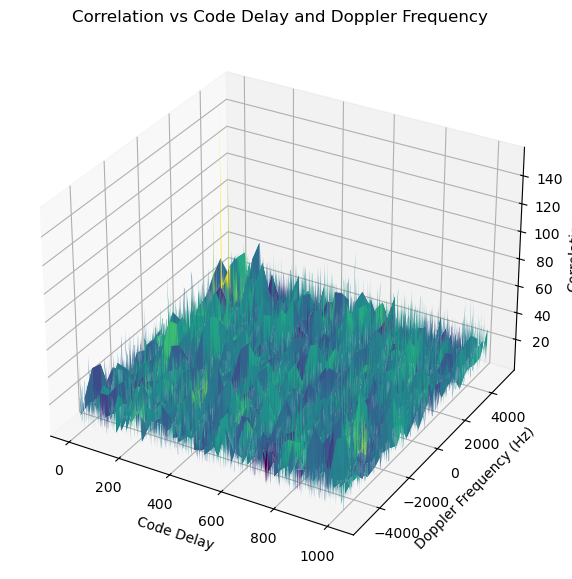

In [987]:
# Plotting
Code_Delay, Doppler_Freq = np.meshgrid(code_delay_range//OV, doppler_freq_range)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Code_Delay, Doppler_Freq, corr_matrix.T, cmap='viridis')
ax.set_xlabel('Code Delay')
ax.set_ylabel('Doppler Frequency (Hz)')
ax.set_zlabel('Correlation')
ax.set_title('Correlation vs Code Delay and Doppler Frequency')
plt.show()



# phase diff

In [988]:

# 신호 1ms씩 쪼개기
signal_div = [received_signal[i:i+(1023*OV)] for i in range(0,len(received_signal), 1023*OV)]

##############
# 20ms 안에서 bit boundary(B) 값 탐색
cor_lst = []
True_replica = generate_replica_signal(estimated_code_delay, estimated_doppler_freq, code_freq, svNumber)
phase  = []
for i in range(ms): #100번 반복
    cor = correlate(signal_div[i], True_replica, mode = 'valid')
    cor_lst.append(np.max(cor)) #cor_lst 얘로 phase 계산
    phase.append(np.arctan2(np.imag(cor), np.real(cor))) #왜 arctan2를 썼을까


phase_diff = []
for i in range(1, ms):
    phase_diff.append((cor_lst[i] * np.conj(cor_lst[i-1])))


Index 0: -140.73674647154763
Index 1: 16.71110576986162
Index 2: -135.64686423135407
Index 3: -134.04769785184268
Index 4: -138.214087496698
Index 5: -132.0020519733516
Index 6: -139.40291455990425
Index 7: -123.6648243833241
Index 8: -135.99006407436994
Index 9: -143.40744544703819
Index 10: -137.8072447539473
Index 11: -119.43113845881989
Index 12: -135.52471530154088
Index 13: -131.3924294575796
Index 14: -146.18342946549666
Index 15: -123.83181050807617
Index 16: -152.65123792164536
Index 17: -122.82647546319967
Index 18: -127.12519769433467
Index 19: -144.80258510234296
Index 20: -132.6766432753689
Index 21: 45.97169133737557
Index 22: -141.71746265549598
Index 23: -130.37097517032853
Index 24: -132.89283444357926
Index 25: -134.5089720905601
Index 26: -135.4753715338777
Index 27: -138.02926834977697
Index 28: -123.03703551036136
Index 29: -140.13175810297167
Index 30: -139.22145868329113
Index 31: -128.1924049317165
Index 32: -137.89875610191905
Index 33: -132.22284789187543
Inde

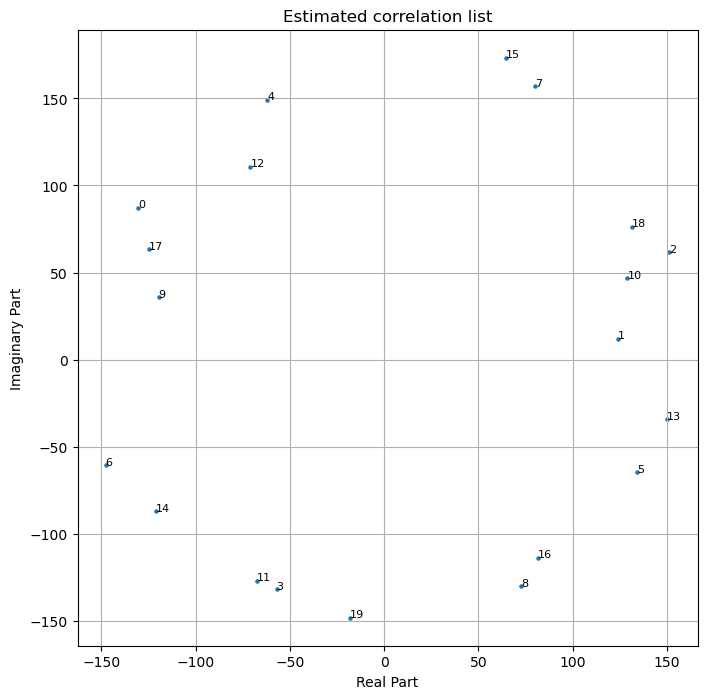

In [989]:
degree_list = [np.degrees(np.angle(value)) for value in phase_diff]

for idx, value in enumerate(degree_list):
    print(f"Index {idx}: {value}")

plt.figure(figsize=(8, 8))
plt.scatter(np.real(cor_lst[:20]), np.imag(cor_lst[:20]), s=5)

for i, txt in enumerate(range(0, 0 + 20)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i]), np.imag(cor_lst[i])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

# 주파수 offset = 0일 때 1~20번은 오른쪽, 21~39번이 왼쪽에 있다면 bit boundary 잘 찾은거.(부호반전)
# 위아래로 돌아간 거는 noise에 의한 영향 + 약간의 주파수 offset과 code delay에 관한 거.

# doppler freq 잡ㅇ...

In [990]:
"""
def remove_outliers(data, outliers):
    clean_data = [value for i, value in enumerate(data) if (i, value) not in outliers]
    return clean_data

# 예시 리스트
data_list = degree_list
def find_outliers(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    outliers = []
    
    for i, value in enumerate(data):
        if abs(value - mean) > 2 * std_dev:  # 임의로 2배의 표준편차 이상을 이상치로 설정
            outliers.append((i, value))
    
    return outliers


outliers = find_outliers(data_list)

# 이상치 제거
cleaned_data = remove_outliers(data_list, outliers)

print("Cleaned degree:")
cleaned_degree = np.mean(cleaned_data)
print(cleaned_degree)






def compensate_frequency_offset(signal, offset_angle_degrees):
    # 주파수 오프셋을 각도에서 라디안으로 변환
    offset_angle_radians = np.radians(offset_angle_degrees)
    
    # 주어진 주파수 오프셋에 해당하는 회전을 적용하여 보상
    compensated_signal = [s * np.exp(1j * offset_angle_radians) for s in signal]
    
    return compensated_signal

# 예시로 주어진 주파수 오프셋
frequency_offset = cleaned_degree  # 각도로 표현된 주파수 오프셋

# 모든 시그널에 주파수 오프셋을 보상해주기 위한 코드
compensated_new = compensate_frequency_offset(cor_lst, frequency_offset)





#이거 아닌것 같은데//
#이럼 걍 돌아가기만 하잖아;

plt.figure(figsize=(8, 8))
plt.scatter(np.real(compensated_new), np.imag(compensated_new), s=5)

for i, txt in enumerate(range(40, 60)):
    plt.annotate(f'{txt}', (np.real(compensated_new[i]), np.imag(compensated_new[i])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

"""

'\ndef remove_outliers(data, outliers):\n    clean_data = [value for i, value in enumerate(data) if (i, value) not in outliers]\n    return clean_data\n\n# 예시 리스트\ndata_list = degree_list\ndef find_outliers(data):\n    mean = np.mean(data)\n    std_dev = np.std(data)\n    outliers = []\n    \n    for i, value in enumerate(data):\n        if abs(value - mean) > 2 * std_dev:  # 임의로 2배의 표준편차 이상을 이상치로 설정\n            outliers.append((i, value))\n    \n    return outliers\n\n\noutliers = find_outliers(data_list)\n\n# 이상치 제거\ncleaned_data = remove_outliers(data_list, outliers)\n\nprint("Cleaned degree:")\ncleaned_degree = np.mean(cleaned_data)\nprint(cleaned_degree)\n\n\n\n\n\n\ndef compensate_frequency_offset(signal, offset_angle_degrees):\n    # 주파수 오프셋을 각도에서 라디안으로 변환\n    offset_angle_radians = np.radians(offset_angle_degrees)\n    \n    # 주어진 주파수 오프셋에 해당하는 회전을 적용하여 보상\n    compensated_signal = [s * np.exp(1j * offset_angle_radians) for s in signal]\n    \n    return compensated_signal\n\

# Bit Boundary
* 거의 pi만큼 돌아가면 못찾는 문제

In [991]:
"""
print(len(degree_list))
for item in degree_list:
    print((item))

# 차이가 다른 값들과 많이 나는 값을 찾는 함수
def find_outlier_new(degree_list):
    # 교차 상관 값들 사이의 차이를 저장할 변수 초기화
    max_difference = 0
    outlier_index = None
    
    # 각 값들 사이의 차이를 계산하여 가장 큰 차이를 갖는 값을 찾음
    #이 for문 안쓰는거니까 빼기
    for i in range(len(degree_list)):
        if degree_list[i]<0:
            degree_list[i] = 360+degree_list[i]
=     
    for i in range(len(degree_list) - 1):
        
        difference = []
        difference = abs(degree_list[i] - degree_list[i + 1])
        if difference > max_difference:
            max_difference = difference
            outlier_index = i
     
    return outlier_index


# 차이가 다른 값들과 많이 나는 값을 찾음
outlier_index = find_outlier_new(degree_list[:40])
#print("**", outlier_index)
if outlier_index>20:
    print("Outlier Index:", outlier_index-20)
else:
    print("Outlier Index:", outlier_index+1)


print(B)
"""

'\nprint(len(degree_list))\nfor item in degree_list:\n    print((item))\n\n# 차이가 다른 값들과 많이 나는 값을 찾는 함수\ndef find_outlier_new(degree_list):\n    # 교차 상관 값들 사이의 차이를 저장할 변수 초기화\n    max_difference = 0\n    outlier_index = None\n    \n    # 각 값들 사이의 차이를 계산하여 가장 큰 차이를 갖는 값을 찾음\n    #이 for문 안쓰는거니까 빼기\n    for i in range(len(degree_list)):\n        if degree_list[i]<0:\n            degree_list[i] = 360+degree_list[i]\n=     \n    for i in range(len(degree_list) - 1):\n        \n        difference = []\n        difference = abs(degree_list[i] - degree_list[i + 1])\n        if difference > max_difference:\n            max_difference = difference\n            outlier_index = i\n     \n    return outlier_index\n\n\n# 차이가 다른 값들과 많이 나는 값을 찾음\noutlier_index = find_outlier_new(degree_list[:40])\n#print("**", outlier_index)\nif outlier_index>20:\n    print("Outlier Index:", outlier_index-20)\nelse:\n    print("Outlier Index:", outlier_index+1)\n\n\nprint(B)\n'

In [992]:
def find_outliers(data):
    outliers = []
    threshold = 1.5 # 일반적으로는 1.5를 사용합니다.

    data_sorted = sorted(data)
    q1, q3 = np.percentile(data_sorted, [25, 75])
    iqr = q3 - q1

    lower_bound = q1 - (threshold * iqr)
    upper_bound = q3 + (threshold * iqr)

    for i, x in enumerate(data):
        if x < lower_bound or x > upper_bound:
            outliers.append(x)

    return outliers


data = degree_list

outliers = find_outliers(data[20:40])
print("이상치:", outliers)



tmp = outliers[0]
print(tmp)
idx = degree_list.index(tmp)

outlier_index = idx
print(outlier_index)

if outlier_index>19:
    outlier_index = outlier_index-19
    
print("estimated B", outlier_index)
print("B", B)


이상치: [45.97169133737557]
45.97169133737557
21
estimated B 2
B 2



# Bit change

In [993]:
print(len(degree_list))


#B 잘못 추정시 문제!
#degree_list = np.roll(degree_list, B)
degree_list = degree_list[outlier_index:] + degree_list[:outlier_index]

for item in degree_list:
    print(item)

99
-135.64686423135407
-134.04769785184268
-138.214087496698
-132.0020519733516
-139.40291455990425
-123.6648243833241
-135.99006407436994
-143.40744544703819
-137.8072447539473
-119.43113845881989
-135.52471530154088
-131.3924294575796
-146.18342946549666
-123.83181050807617
-152.65123792164536
-122.82647546319967
-127.12519769433467
-144.80258510234296
-132.6766432753689
45.97169133737557
-141.71746265549598
-130.37097517032853
-132.89283444357926
-134.5089720905601
-135.4753715338777
-138.02926834977697
-123.03703551036136
-140.13175810297167
-139.22145868329113
-128.1924049317165
-137.89875610191905
-132.22284789187543
-140.68708478998875
-127.27157814237526
-141.00698699539723
-146.74155215243684
-130.5326355167875
-126.21068870934874
-134.54925819822887
40.865173134475825
-125.51103390708938
-147.35404954167282
-130.60889369992688
-131.28817193489553
-132.99814595518347
-129.15456879523356
-145.65637804892395
-135.5544314552436
-127.83377647583845
-132.51337197268256
-135.7526417

In [994]:
print(degree_list[19], degree_list[20])
print(degree_list[38], degree_list[39])
print(degree_list[58], degree_list[59])
print(degree_list[78], degree_list[79])

45.97169133737557 -141.71746265549598
-134.54925819822887 40.865173134475825
-126.48216290667436 36.90861667867694
-132.16398867503608 43.324982542384625


In [995]:
import cmath

cor_lst = np.roll(cor_lst,outlier_index)
phase_diff = np.roll(phase_diff,outlier_index)


cor_lst_1 = cor_lst[:20]
cor_lst_2 = cor_lst[20:40] 
cor_lst_3 = cor_lst[40:60]
cor_lst_4 = cor_lst[60:80]
cor_lst_5 = cor_lst[80:100]




new_s_1 = [0] * (len(cor_lst_1))  # cor_lst의 길이보다 하나 작은 크기의 빈 리스트 생성

cumulative_phase = 0 #맨 첫번째건 여기서 계산
new_s_1[0] = cor_lst_1[0]
for i in range(len(cor_lst_1[1:])): #0~18까지  
    cumulative_phase += cmath.phase(phase_diff[i]) #phase diff는 무조건 0부터 18
    new_s_1[i+1] = cor_lst_1[i+1] * cmath.exp(-1j * cumulative_phase)

print(len(new_s_1),new_s_1)




"""
if (degree_list[19]) > (np.mean(degree_list[:18])) or (degree_list[19]) < (np.mean(degree_list[:18])):
    cumulative_phase += np.pi
    print("bit change")

"""    
if abs((degree_list[19])-(degree_list[20])) > 45:
    cumulative_phase += np.pi
    print("bit change")
    
new_s_2 = [0] * (len(cor_lst_2))  # cor_lst의 길이보다 하나 작은 크기의 빈 리스트 생성
#cumulative_phase = 0
#cumulative_phase += np.pi
for i in range(len(cor_lst_2)):
    cumulative_phase += cmath.phase(phase_diff[19+i]) #19부터 ~ 38까지
    new_s_2[i] = cor_lst_2[i] * cmath.exp(-1j * cumulative_phase)

print(len(new_s_2),new_s_2)






if abs((degree_list[39])-(degree_list[40])) > 45:
    cumulative_phase += np.pi
    print("bit change")

new_s_3 = [0] * (len(cor_lst_3))  # cor_lst의 길이보다 하나 작은 크기의 빈 리스트 생성

#cumulative_phase = 0
#cumulative_phase += np.pi
for i in range(len(cor_lst_3)):
    cumulative_phase += cmath.phase(phase_diff[39+i])
    new_s_3[i] = cor_lst_3[i] * cmath.exp(-1j * cumulative_phase)


print(len(new_s_3),new_s_3)




if abs((degree_list[59])-(degree_list[60])) > 45:
    cumulative_phase += np.pi
    print("bit change")

new_s_4 = [0] * (len(cor_lst_4))  # cor_lst의 길이보다 하나 작은 크기의 빈 리스트 생성

#cumulative_phase = 0
#cumulative_phase += np.pi/2
for i in range(len(cor_lst_4)):
    cumulative_phase += cmath.phase(phase_diff[59+i])
    new_s_4[i] = cor_lst_4[i] * cmath.exp(-1j * cumulative_phase)

print(len(new_s_4),new_s_4)






if abs((degree_list[79])-(degree_list[80])) > 45:
    cumulative_phase += np.pi
    print("bit change")

new_s_5 = [0] * (len(cor_lst_5))  # cor_lst의 길이보다 하나 작은 크기의 빈 리스트 생성

#cumulative_phase = 0
#cumulative_phase += np.pi/2
for i in range(0,len(cor_lst_5)):
    cumulative_phase += cmath.phase(phase_diff[79+i])
    new_s_5[i] = cor_lst_5[i] * cmath.exp(-1j * cumulative_phase)

print(len(new_s_5),new_s_5)


20 [(73.04031871482175+129.55680377203606j), (60.42311479620324+110.84582917851395j), (74.89165045145914+137.8315871820146j), (59.56776500431684+109.62930508190297j), (78.0389156912483+143.6238558884452j), (68.5715952068028+126.20007365283146j), (77.14240726722076+141.97390988964725j), (71.1784548361075+130.9977727034177j), (76.24380700516244+140.32011404438197j), (84.14155283335595+154.85523025691043j), (71.16452646633473+130.9721387468798j), (59.67008122121631+109.8176092050548j), (65.51215584932132+120.56944086550686j), (68.63853923461782+126.3232783298602j), (62.825897838228265+115.62561597958856j), (73.40688741481719+135.09900958897077j), (71.11726868528493+130.88516489959994j), (88.35167754989105+162.60359964676837j), (66.87494606370788+123.07753805808595j), (66.85283352199795+123.03684184292632j)]
bit change
20 [(-72.52235723299569-133.47110850606038j), (-71.26447782301341-131.1560905499022j), (-75.42363412264743-138.8106569890288j), (-79.69706070709108-146.67552797650296j), (-7

[-140.73674647154763, 16.71110576986162, -135.64686423135407, -134.04769785184268, -138.214087496698, -132.0020519733516, -139.40291455990425, -123.6648243833241, -135.99006407436994, -143.40744544703819, -137.8072447539473, -119.43113845881989, -135.52471530154088, -131.3924294575796, -146.18342946549666, -123.83181050807617, -152.65123792164536, -122.82647546319967, -127.12519769433467, -144.80258510234296, -132.6766432753689, 45.97169133737557, -141.71746265549598, -130.37097517032853, -132.89283444357926, -134.5089720905601, -135.4753715338777, -138.02926834977697, -123.03703551036136, -140.13175810297167, -139.22145868329113, -128.1924049317165, -137.89875610191905, -132.22284789187543, -140.68708478998875, -127.27157814237526, -141.00698699539723, -146.74155215243684, -130.5326355167875, -126.21068870934874, -134.54925819822887, 40.865173134475825, -125.51103390708938, -147.35404954167282, -130.60889369992688, -131.28817193489553, -132.99814595518347, -129.15456879523356, -145.65

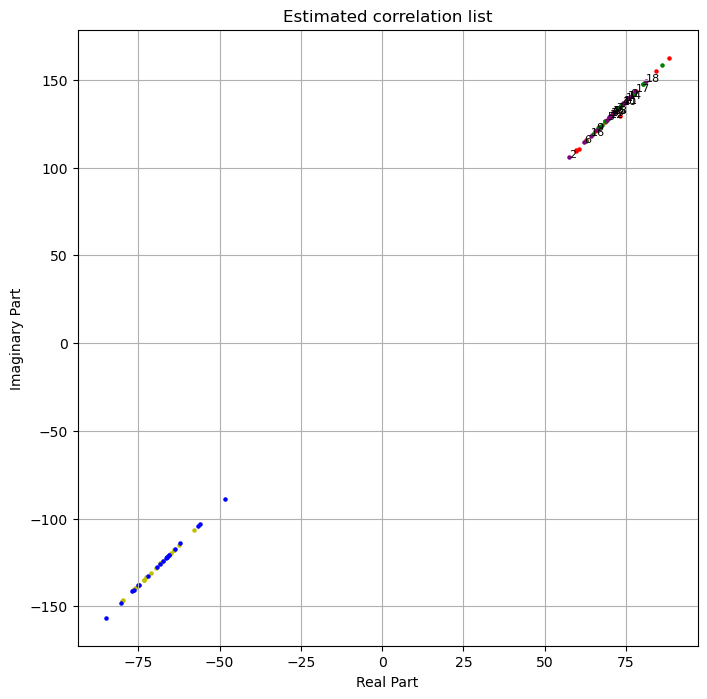

In [996]:
print(data)

plt.figure(figsize=(8, 8))
plt.scatter(np.real(new_s_1), np.imag(new_s_1), s=5, label='New_s_1', c='r')
plt.scatter(np.real(new_s_2), np.imag(new_s_2), s=5, label='New_s_2', c='y')
plt.scatter(np.real(new_s_3), np.imag(new_s_3), s=5, label='New_s_3', c='g')
plt.scatter(np.real(new_s_4), np.imag(new_s_4), s=5, label='New_s_4', c='b')
plt.scatter(np.real(new_s_5), np.imag(new_s_5), s=5, label='New_s_5', c='purple')


for i, txt in enumerate(range(0, 20)):
    plt.annotate(f'{txt}', (np.real(new_s_5[i]), np.imag(new_s_5[i])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()


# demodulation

In [997]:
import numpy as np

def mean_angle(complex_numbers):
    # 복소수를 극 좌표로 변환하여 각도 추출
    angles = np.angle(complex_numbers)
    
    # 각도를 라디안에서 [-pi, pi) 범위로 변환
    angles_wrapped = np.unwrap(angles)
    
    # 평균 각도 계산
    mean_wrapped_angle = np.mean(angles_wrapped)
    
    # [-pi, pi) 범위 내의 각도로 변환
    mean_angle = np.angle(np.exp(1j * mean_wrapped_angle))
    
    return mean_angle


def mean_angle_degrees(complex_numbers):
    mean_angle_radians = mean_angle(complex_numbers)
    mean_angle_degrees = np.degrees(mean_angle_radians)
    return mean_angle_degrees

# new_s_1 리스트의 평균 각도(디그리) 계산
mean_angle_new_s_1_degrees = mean_angle_degrees(new_s_1[:])
print("new_s_1 리스트의 평균 각도(디그리):", mean_angle_new_s_1_degrees)

mean_angle_new_s_2_degrees = mean_angle_degrees(new_s_2)
print("new_s_2 리스트의 평균 각도(디그리):", mean_angle_new_s_2_degrees)

mean_angle_new_s_3_degrees = mean_angle_degrees(new_s_3)
print("new_s_3 리스트의 평균 각도(디그리):", mean_angle_new_s_3_degrees)

mean_angle_new_s_4_degrees = mean_angle_degrees(new_s_4)
print("new_s_4 리스트의 평균 각도(디그리):", mean_angle_new_s_4_degrees)

mean_angle_new_s_5_degrees = mean_angle_degrees(new_s_5)
print("new_s_5 리스트의 평균 각도(디그리):", mean_angle_new_s_5_degrees)

new_s_1 리스트의 평균 각도(디그리): 61.43363928795823
new_s_2 리스트의 평균 각도(디그리): -118.51772038731428
new_s_3 리스트의 평균 각도(디그리): 61.48227961268504
new_s_4 리스트의 평균 각도(디그리): -118.51772038731833
new_s_5 리스트의 평균 각도(디그리): 61.48227961267949


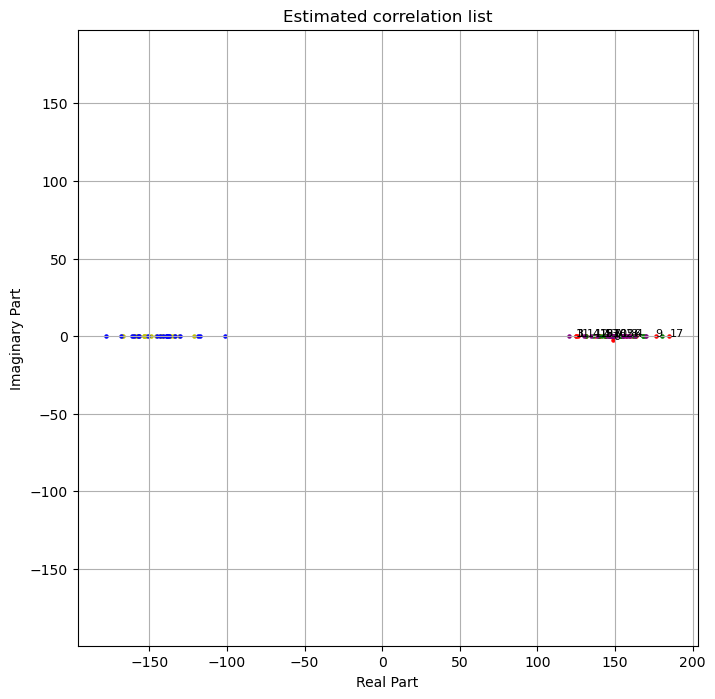

In [998]:
import numpy as np

def rotate_complex_signal(signal, angle_degrees):
    # 각도를 라디안으로 변환
    angle_radians = np.radians(angle_degrees)
    
    # 복소수로 변환
    complex_signal = np.array(signal)
    
    # 복소수에 지수 함수 적용하여 회전
    rotated_signal = complex_signal * np.exp(-1j * angle_radians)
    
    return rotated_signal

# new_s_1 리스트를 계산된 평균 각도만큼 돌림
rotated_new_s_1 = rotate_complex_signal(new_s_1, mean_angle_new_s_1_degrees)
rotated_new_s_2 = rotate_complex_signal(new_s_2, mean_angle_new_s_1_degrees)
rotated_new_s_3 = rotate_complex_signal(new_s_3, mean_angle_new_s_1_degrees)
rotated_new_s_4 = rotate_complex_signal(new_s_4, mean_angle_new_s_1_degrees)
rotated_new_s_5 = rotate_complex_signal(new_s_5, mean_angle_new_s_1_degrees)



plt.figure(figsize=(8, 8))
plt.scatter(np.real(rotated_new_s_1), np.imag(rotated_new_s_1), s=5, label='New_s_1', c='r')
plt.scatter(np.real(rotated_new_s_2), np.imag(rotated_new_s_2), s=5, label='New_s_2', c='y')
plt.scatter(np.real(rotated_new_s_3), np.imag(rotated_new_s_3), s=5, label='New_s_3', c='g')
plt.scatter(np.real(rotated_new_s_4), np.imag(rotated_new_s_4), s=5, label='New_s_4', c='b')
plt.scatter(np.real(rotated_new_s_5), np.imag(rotated_new_s_5), s=5, label='New_s_5', c='purple')

# x와 y축의 단위를 같게 설정
plt.axis('equal')

for i, txt in enumerate(range(0, 20)):
    plt.annotate(f'{txt}', (np.real(rotated_new_s_1[i]), np.imag(rotated_new_s_1[i])), fontsize = 8)
    


plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()


In [999]:
def determine_quadrant(points):
    quadrant_sum = 0
    for point in points:
        real_part = np.real(point)
        imag_part = np.imag(point)
        
        if real_part > 0 and imag_part > 0:  # 1사분면
            quadrant_sum += 1
        elif real_part < 0 and imag_part > 0:  # 2사분면
            quadrant_sum -= 1
        elif real_part < 0 and imag_part < 0:  # 3사분면
            quadrant_sum -= 1
        elif real_part > 0 and imag_part < 0:  # 4사분면
            quadrant_sum += 1
    
    if quadrant_sum > 0:
        return 1
    elif quadrant_sum < 0:
        return -1
    else:
        return 0  # 사분면이 균형을 이루는 경우



result_1 = determine_quadrant(rotated_new_s_1)
result_2 = determine_quadrant(rotated_new_s_2)
result_3 = determine_quadrant(rotated_new_s_3)
result_4 = determine_quadrant(rotated_new_s_4)
result_5 = determine_quadrant(rotated_new_s_5)


print("demodulation result!", "\n")
if result_1 == 1:
    print("1")
else:
    print("-1")
if result_2 == 1:
    print("1")
else:
    print("-1")
if result_3 == 1:
    print("1")
else:
    print("-1")
if result_4 == 1:
    print("1")
else:
    print("-1")
if result_5 == 1:
    print("1")
else:
    print("-1")    



demodulation result! 

1
-1
1
-1
1


## 밑에는

## 작업중

## 병렬구조 만들기 (Demod, DLL 하기 전)

신호를 I, Q로 쪼갠 뒤 각각을 계산해야함

In [1000]:
# Extract real and imaginary parts separately
def spliter(signal):
    return np.real(signal), np.imag(signal)

real_part, imaginary_part = spliter(received_signal)

cur_code_delay = estimated_code_delay

E = generate_replica_signal(cur_code_delay - (OV // 2), estimated_doppler_freq, code_freq, svNumber)
P = generate_replica_signal(cur_code_delay, estimated_doppler_freq, code_freq, svNumber)
L = generate_replica_signal(cur_code_delay + (OV // 2), estimated_doppler_freq, code_freq, svNumber)

Real_E, Imag_E = spliter(E)
Real_P, Imag_P = spliter(P)
Real_L, Imag_L = spliter(L)

signal_div_Real = [real_part[i:i+(1023*OV)] for i in range(0,len(real_part), 1023*OV)]
signal_div_Imaginary = [imaginary_part[i:i+(1023*OV)] for i in range(0,len(imaginary_part), 1023*OV)]

def I_and_D(signal, replica):
    correlation = []
    for lst in signal:
        cor = correlate(lst, replica,mode='valid')
        correlation.append(np.max(cor))
    return list(correlation)

I_E = I_and_D(signal_div_Real, Real_E)
Q_E = I_and_D(signal_div_Imaginary, Imag_E)
I_P = I_and_D(signal_div_Real, Real_P)
Q_P = I_and_D(signal_div_Imaginary, Imag_P)
I_L = I_and_D(signal_div_Real, Real_L)
Q_L = I_and_D(signal_div_Imaginary, Imag_L)


print(I_E)
print(Q_E)
print(I_P)
print(Q_P)
print(I_L)
print(Q_L)

[-60.849356715566145, 44.43906643533126, 52.744653397133504, -9.08086059199881, -22.744659697050913, 49.28633635754957, -60.28469857077109, 21.254045487910968, 16.13903868642992, -37.621169133871376, 53.18528327386266, -29.03565505559179, -34.22434606247161, 44.89073250090368, -49.18383781063134, 4.541151455028581, 34.18585053555127, -33.43146162136637, 47.246489902479524, -15.179301680713467, -34.27837420288245, 54.26291002931796, 49.8829017666337, -29.257957372482444, -36.47255998147493, 51.26971108779874, -45.809722338336755, 13.103318446500001, 11.44498751559036, -58.623172385557325, 44.769604937728154, -8.55060603401877, -45.54727395604985, 41.434500686633754, -48.956482647266256, 28.66747902711817, 26.108524270023146, -45.21299809805037, 39.5266409254715, -7.591311377964098, -32.6355669389829, 63.10454228062318, 50.31105023099453, 9.831133386992228, -24.81270678903222, 65.68657580115345, -24.43373217163148, -0.7997561819571697, 28.439234868702158, -57.348861040438386, 43.43264344

In [1001]:
#incoming signal 받고
#NCO carrier generator에서 받아와서 sin, cos 곱해
#여기까지  signal * sin, signal * cos


#그거랑 PRN이랑 곱해(E,P,L)
#여기까지 signal*sin*PRN...


# Residual code/carrier phase
remCodePhase = 0.0

# define residual carrier phase
remCarrPhase  = 0.0

# code tracking loop parameters
oldCodeNco   = 0.0
oldCodeError = 0.0

# carrier/Costas loop parameters
oldCarrNco = 0.0
oldCarrError = 0.0

dataPosition = 0
blksize = 0


carrFreq = -3363.8
fs = 1023*OV*1000
codeLength = 1023
earlyLateSpacing = 0.5
chippingRate = 1023000
codeFreq = 1023000







In [1002]:
# 91p
# Calculate filter coefficient values for code loop
def calculate_loop_coefficients(loop_noise_bandwidth, zeta, loop_gain, sum_int):
    """
    Calculates the loop coefficients tau1 and tau2.

    This process is discussed in sections 7.1-7.3 of Borre.

    Parameters:
    loop_noise_bandwidth (float): Loop noise bandwidth.
    zeta (float): Damping ratio.
    loop_gain (float): Loop gain.
    sum_int (float): Summation interval.

    Returns:
    tuple: Coefficient 1 (coeff1) and Coefficient 2 (coeff2).
    """
    # Solve for the natural frequency
    wn = loop_noise_bandwidth * 8 * zeta / (4 * zeta**2 + 1)

    # Solve for tau1 and tau2
    tau1 = loop_gain / (wn * wn)
    tau2 = (2.0 * zeta) / wn

    coeff1 = tau2 / tau1
    coeff2 = float(sum_int) / tau1

    return coeff1, coeff2


#91p참고 (loop_gain, sum_int는 모르겠다)
loop_noise_bandwidth = 20
zeta = 0.7
loop_gain = 1
sum_int = 1e-3
#coeffCode1, coeffCode2 = calculate_loop_coefficients(loop_noise_bandwidth,zeta,loop_gain,sum_int)
#coeffCar1, coeffCar2 = calculate_loop_coefficients(loop_noise_bandwidth,zeta,loop_gain,sum_int)
coeffCode1, coeffCode2 = 5.2972972972972965, 0.014317019722425127
coeffCar1, coeffCar2 = 264.86486486486484, 8.948137326515706

print(coeffCode1, coeffCode2)
print(coeffCar1, coeffCar2)

t_code = [item for item in t_code for _ in range(10)]

5.2972972972972965 0.014317019722425127
264.86486486486484 8.948137326515706


In [1003]:

#Store the shift registers as a deque, so that deque.rotate() can be used.
from collections import deque  
import numpy as np

'''
GPS Gold Code generator. Initialized with the feedback taps for one satellite.
'''

#Feedback taps as defined in GPS spec
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]


def getCode(num, zero = False, samplesPerChip = 1, prn = 0):
    '''
    Returns a list of bits that form the Gold Code PRN of the designated satellite
    
    zero flag determines whether 0 or -1 is returned
    '''
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
    
        
    g = []

    for i in range(num):
        val = (g1[9] + g2[prn[0]] + g2[prn[1]]) % 2
        g.append(val)

        #Shift g1
        g1[9] = sum([g1[i] for i in g1tap]) % 2 
        g1.rotate()

        #Shift g2
        g2[9] = sum([g2[i] for i in g2tap]) % 2 
        g2.rotate()

    if(zero == False):
        #format GC to have -1 in place of 0
        for n,i in enumerate(g):
            if i==0:
                g[n]=-1
    
    if (samplesPerChip > 1 ):
        # Repeat each chip to match our ADC sample frequency
        gsamp = np.repeat(g, samplesPerChip)
        return gsamp
    return g

def getTrackingCode(sat):
    '''
    Returns a code ready to be used by Tracking.py
    '''
    code = np.array(getCode(1023, prn = sats[sat - 1]))

    # Need to add extra code chips to the ends so that it can 'slide'
    # back and forth during tracking.
    code = np.append(code,code[0])
    code = np.insert(code,0, code[len(code) - 2])
    return code


def getAcquisitionCode(sat, spc):
    '''
    Returns a code ready to be used by Acquisition.py
    '''
    return getCode(1023, samplesPerChip = spc, prn = sats[sat-1])



## Tracking loop test

In [1004]:

import numpy as np
import matplotlib.pyplot as plt
import configparser



# code tracking loop parameters
oldCodeNco   = 0.0
oldCodeError = 0.0

# carrier/Costas loop parameters
oldCarrNco   = 0.0
oldCarrError = 0.0

acquiredCarrFreq = estimated_doppler_freq
chippingRate = code_freq #codeFreqBasis

dataPosition = 0
CACode = getTrackingCode(RN)

I_P_list = []

# Process the requested number of code periods (num of ms to process)
for i in range(0, ms):
    print("\n------- %2.1f percent complete --------"%((i/ms)*100), end = '\r')
    # Find PLL error and update carrier NCO
    # Implement carrier loop discriminator (phase detector)

    # Update the phasestep based on code freq (variable) and
    # sampling frequency (fixed)
    codePhaseStep = np.real(codeFreq / fs) #맨아래에서 업데이트 시킨 codeFreq여기서 사용-LOOP
    
    
    #print("Old blksize: %d"%blksize)
    blksize = int(np.ceil((codeLength-remCodePhase) / codePhaseStep))
    #print("New blksize: %d"%blksize)
    #print("Old remCodePhase: %f" %remCodePhase)

    # Read in the appropriate number of samples to process this
    # iteration
    rawSignal = received_signal[dataPosition:dataPosition+blksize]
    dataPosition = dataPosition + blksize


    
    # Generate Early CA Code.
    tStart = remCodePhase - earlyLateSpacing
    tStep = codePhaseStep
    tEnd = ((blksize-1)*codePhaseStep+remCodePhase) + codePhaseStep - earlyLateSpacing
    tcode = np.linspace(tStart,tEnd,blksize,endpoint=False)
    tcode2 = (np.ceil(tcode)).astype(int)
    earlyCode = CACode[tcode2]




    # Generate Late CA Code.
    tStart = remCodePhase + earlyLateSpacing
    tStep = codePhaseStep
    tEnd = ((blksize-1)*codePhaseStep+remCodePhase) + codePhaseStep + earlyLateSpacing
    tcode = np.linspace(tStart,tEnd,blksize,endpoint=False)
    tcode2 = (np.ceil(tcode)).astype(int)
    lateCode = CACode[tcode2]


    # Generate Prompt CA Code.
    tStart = remCodePhase
    tStep = codePhaseStep
    tEnd = ((blksize-1)*codePhaseStep+remCodePhase) + codePhaseStep
    tcode = np.linspace(tStart,tEnd,blksize,endpoint=False)
    tcode2 = (np.ceil(tcode)).astype(int)
    promptCode = CACode[tcode2]

    
    
    # Figure out remaining code phase (uses tcode from Prompt CA Code generation):
    remCodePhase = (t_code[blksize-1]) - 1023.00   #t_code: 10230
    if abs(remCodePhase) > codePhaseStep:
        remCodePhase = np.sin(remCodePhase)*codePhaseStep
    else:
        remCodePhase = 0


    # Generate the carrier frequency to mix the signal to baseband
    time = np.array(range(0,blksize+1))/fs
    
    #print("Length of time array for cos and sin: %d" %len(time))
    # Get the argument to sin/cos functions
    trigarg = ((carrFreq * 2.0 * np.pi) * time) + remCarrPhase
    
    # Carry the leftover phase to the next argument by looking at the last element
    #remCarrPhase = trigarg[blksize] % (2 * np.pi)
    remCarrPhase_real = trigarg[blksize-1].real % (2 * np.pi)
    remCarrPhase_imag = trigarg[blksize-1].imag % (2 * np.pi)
    remCarrPhase = remCarrPhase_real + 1j * remCarrPhase_imag


    # Finally compute the signal to mix the collected data to baseband
    carrCos = np.cos(trigarg[0:blksize])
    carrSin = np.sin(trigarg[0:blksize])
    
    # First mix to baseband
    #print(len(carrCos), len(rawSignal))
    qBasebandSignal = carrCos * rawSignal #38192, 30026
    iBasebandSignal = carrSin * rawSignal
    
    # Now get early, late, and prompt values for each
    I_E = np.sum(earlyCode  * iBasebandSignal) #1023, 38192
    Q_E = np.sum(earlyCode  * qBasebandSignal)
    I_P = np.sum(promptCode * iBasebandSignal)
    Q_P = np.sum(promptCode * qBasebandSignal)
    I_L = np.sum(lateCode   * iBasebandSignal)
    Q_L = np.sum(lateCode   * qBasebandSignal)
    
    I_P_list.append(I_P + Q_P)


    carrError = np.arctan(Q_P / I_P) / (2.0 * np.pi)
    #print(Q_P[i])
    
    # Implement carrier loop filter and generate NCO command
    carrNco = oldCarrNco + coeffCar1 * (carrError - oldCarrError) + carrError * coeffCar2
    oldCarrNco   = carrNco
    oldCarrError = carrError

    # Modify carrier freq based on NCO command
    carrFreq = acquiredCarrFreq + carrNco





    # Find DLL error and update code NCO -------------------------------------
    codeError = (np.sqrt(I_E * I_E + Q_E * Q_E) - np.sqrt(I_L * I_L + Q_L * Q_L)) /\
                            (np.sqrt(I_E * I_E + Q_E * Q_E) + np.sqrt(I_L * I_L + Q_L * Q_L))
    
    # Implement code loop filter and generate NCO command
    codeNco = oldCodeNco + coeffCode1 * (codeError - oldCodeError) + codeError * coeffCode2
    oldCodeNco   = codeNco
    oldCodeError = codeError
    
    # Modify code freq based on NCO command
    codeFreq = chippingRate - codeNco





#print(codeNco)
#print(codeFreq)
#print(codeError)
#print(carrError)


------- 0.0 percent complete --------
------- 1.0 percent complete --------
------- 2.0 percent complete --------
------- 3.0 percent complete --------
------- 4.0 percent complete --------
------- 5.0 percent complete --------
------- 6.0 percent complete --------
------- 7.0 percent complete --------
------- 8.0 percent complete --------
------- 9.0 percent complete --------
------- 10.0 percent complete --------
------- 11.0 percent complete --------
------- 12.0 percent complete --------
------- 13.0 percent complete --------
------- 14.0 percent complete --------
------- 15.0 percent complete --------
------- 16.0 percent complete --------
------- 17.0 percent complete --------
------- 18.0 percent complete --------
------- 19.0 percent complete --------
------- 20.0 percent complete --------
------- 21.0 percent complete --------
------- 22.0 percent complete --------
------- 23.0 percent complete --------
------- 24.0 percent complete --------
------- 25.0 percent complete ----

Demodulation

In [1005]:
Prompt = []
for i in range(len(I_P_list)):
    if I_P_list[i] > 0:
        Prompt.append(1)
    else:
        Prompt.append(-1)

print(len(data))
print('data :', *data, sep = " ",)

print(len(Prompt))
print('est :', *Prompt, sep = " ")
# 리스트를 20개씩 묶기
grouped_lists = [Prompt[i:i+20] for i in range(0, len(Prompt), 20)]

# 각 그룹의 평균을 계산하고, 1 또는 -1로 변환하여 새로운 리스트 생성
result_lists = []
for group in grouped_lists:
    avg = sum(group) / len(group)
    result_lists.append(1 if avg > 0 else -1) 

# 결과 출력
print("\n\nresult", result_lists)



99
data : -140.73674647154763 16.71110576986162 -135.64686423135407 -134.04769785184268 -138.214087496698 -132.0020519733516 -139.40291455990425 -123.6648243833241 -135.99006407436994 -143.40744544703819 -137.8072447539473 -119.43113845881989 -135.52471530154088 -131.3924294575796 -146.18342946549666 -123.83181050807617 -152.65123792164536 -122.82647546319967 -127.12519769433467 -144.80258510234296 -132.6766432753689 45.97169133737557 -141.71746265549598 -130.37097517032853 -132.89283444357926 -134.5089720905601 -135.4753715338777 -138.02926834977697 -123.03703551036136 -140.13175810297167 -139.22145868329113 -128.1924049317165 -137.89875610191905 -132.22284789187543 -140.68708478998875 -127.27157814237526 -141.00698699539723 -146.74155215243684 -130.5326355167875 -126.21068870934874 -134.54925819822887 40.865173134475825 -125.51103390708938 -147.35404954167282 -130.60889369992688 -131.28817193489553 -132.99814595518347 -129.15456879523356 -145.65637804892395 -135.5544314552436 -127.83

결과 Plot